<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_6_%EA%B7%B8%EB%A3%B9_%EC%84%B8%EB%B6%84%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## Install

In [1]:
!pip install fastcluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 194 kB 4.2 MB/s 


In [51]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700845 sha256=43124ebe13a2b323a272c69328c2b9edc0d43f1a71139aac92dfbb4ae997cd09
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


## Library

In [2]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [5]:
from sklearn.impute import SimpleImputer

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [52]:
import hdbscan

# Load Data Set

## Google Drive Mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 탐색하기

In [8]:
file_path = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/LoanStats3a.csv'

In [14]:
data = pd.read_csv(file_path)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [17]:
print(data.shape)
data.head()

(42542, 37)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


# Preprocessing

## 문자형을 숫자형으로 변환

In [18]:
objectFeats = [x for x in data.columns if data[x].dtype == 'object']
objectFeats

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d']

In [19]:
for i in ["term","int_rate","emp_length","revol_util"]:

    data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

## 결측값 대체

In [20]:
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [21]:
# NaNs 을 평균으로 대체
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# NaNs 을 0으로 대체
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

In [22]:
im = SimpleImputer(strategy='mean')
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [23]:
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

## 피처 엔지니어링

In [24]:
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', 
            'revol_balOverIncome','totalPymntOverIncome', 
            'totalPymntInvOverIncome','totalRecPrncpOverIncome', 
            'totalRecIncOverIncome']

## 스케일링

In [25]:
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# 데이터 스케일
sX = StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

## 레이블 지정

In [26]:
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [28]:
# 결측 레이블 채우기
labels = labels.fillna(value="Z")

# 레이블을 숫자형으로 변환
lbl = LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

# y_train에 저장
y_train = labels

In [29]:
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
...,...,...
42537,0,A
42538,7,NaN
42539,7,NaN
42540,7,NaN


# 대출 등급별 이자율 비교

In [30]:
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


# 군집 적합도 검증

In [31]:
def analyzeCluster(clusterDF, labelsDF):

    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, 
                                     left_on="cluster",
                                     right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum() / accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent / accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

## k - Mean

In [34]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2022

In [35]:
kmeans = KMeans(n_clusters=n_clusters,
                n_init=n_init,
                max_iter=max_iter, 
                tol=tol,
                random_state=random_state)

In [36]:
kMeans_inertia = pd.DataFrame(data=[],
                              index=range(10,31), 
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],
                                        index=range(10,31),
                                        columns=['overallAccuracy'])

In [38]:
for n_clusters in range(10,31):

    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol, 
                    random_state=random_state)

    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, 
                                           index=X_train.index,
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans \
    =analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

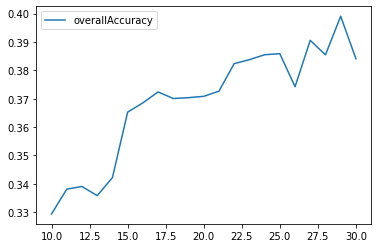

In [39]:
overallAccuracy_kMeansDF.plot()

In [40]:
accuracyByLabel_kMeans

0     0.515865
1     0.319544
2     0.309129
3     0.388828
4     0.340026
5     0.368074
6     0.570270
7     0.266667
8     0.247325
9     0.371703
10    0.260933
11    0.327044
12    0.326750
13    0.241517
14    0.254198
15    0.346863
16    0.669166
17    0.294118
18    0.231813
19    0.288416
20    0.250000
21    0.495334
22    0.204762
23    0.256824
24    0.329293
25    0.305731
26    0.350970
27    0.270557
28    0.500000
29    0.264069
dtype: float64

## 계층적 클러스터링

In [41]:
Z = fastcluster.linkage_vector(X_train, method='ward', 
                               metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,
                           columns=['clusterOne', 'clusterTwo','distance','newClusterSize'])

In [42]:
Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42538.0,42539.0,0.000000e+00,2.0
3,42540.0,42544.0,0.000000e+00,3.0
4,42541.0,42545.0,3.399350e-17,4.0
5,42543.0,42546.0,5.139334e-17,7.0
6,33251.0,33261.0,1.561308e-01,2.0
7,42512.0,42535.0,3.342636e-01,2.0
8,42219.0,42316.0,3.368215e-01,2.0
9,6112.0,21928.0,3.384364e-01,2.0


In [43]:
Z_dataFrame[42521:]

,clusterOne,clusterTwo,distance,newClusterSize
42521,85015.0,85060.0,137.057499,10219.0
42522,85039.0,85043.0,142.729996,1611.0
42523,85052.0,85053.0,144.083353,2821.0
42524,85031.0,85032.0,146.017639,2348.0
42525,85027.0,85047.0,148.177506,4290.0
42526,85028.0,85058.0,161.744188,3809.0
42527,85061.0,85064.0,164.667102,1696.0
42528,85051.0,85067.0,171.639806,4684.0
42529,85035.0,85068.0,172.039988,6159.0
42530,85040.0,85050.0,172.962242,2451.0


In [44]:
distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')

X_train_hierClustered = pd.DataFrame(data=clusters, 
                                     index=X_train.index,
                                     columns=['cluster'])

In [45]:
print("Number of distinct clusters: ", 
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  30


In [46]:
countByCluster_hierClust, countByLabel_hierClust, \
countMostFreq_hierClust, accuracyDF_hierClust, \
overallAccuracy_hierClust, accuracyByLabel_hierClust \
=analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", 
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3617836490997132


In [47]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.356886
1     0.251955
2     0.238896
3     0.265285
4     0.265096
5     0.314560
6     0.500000
7     0.289157
8     0.284314
9     0.321405
10    0.241816
11    0.302752
12    0.317839
13    0.409361
14    0.344310
15    0.327362
16    0.284783
17    0.349750
18    0.723155
19    0.664710
20    0.333787
21    0.230964
22    0.421555
23    0.308782
24    0.294118
25    0.232877
26    0.289787
27    0.242525
28    0.234428
29    0.339048
dtype: float64

## HDBSCAN

In [48]:
min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

In [53]:
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                      min_samples=min_samples,
                      alpha=alpha, 
                      cluster_selection_method=cluster_selection_method)

In [54]:
X_train_hdbscanClustered = hdb.fit_predict(X_train)
X_train_hdbscanClustered = pd.DataFrame(data=X_train_hdbscanClustered,
                                        index=X_train.index,
                                        columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
=analyzeCluster(X_train_hdbscanClustered, y_train)

In [55]:
print("Overall accuracy from HDBSCAN: ", overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.32403272060551924


In [56]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,32810
1,7,3971
2,2,3668
3,1,1097
4,4,773
5,0,120
6,6,42
7,3,38
8,5,23


In [57]:
accuracyByLabel_hdbscan

0    0.284395
1    0.341667
2    0.413856
3    0.332061
4    0.552632
5    0.438551
6    0.391304
7    0.428571
8    0.592798
dtype: float64